In [13]:
import uproot
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from read_low_level import read_file
# Remove this line: from matplotlib.ticker import ScientificFormatter
import seaborn as sns
from sklearn.model_selection import train_test_split

# Create output directory for figures
os.makedirs("figures", exist_ok=True)

In [14]:
# Load Data

# Load the original data
data = np.load("preprocessed/original_data.npz")
event_data = data['event_data']
x_particles = data['x_particles']
columns = data['columns'].tolist()
all_df = pd.DataFrame(event_data, columns=columns)

# Load preprocessed data
lvbb_data = np.load('preprocessed/lvbb_data.npz')
qqbb_data = np.load('preprocessed/qqbb_data.npz')

# Extract data
x_particles_lvbb = lvbb_data['x_particles']
y_labels_lvbb = lvbb_data['y_labels']
weights_lvbb = lvbb_data['weights']

x_particles_qqbb = qqbb_data['x_particles']
y_labels_qqbb = qqbb_data['y_labels']
weights_qqbb = qqbb_data['weights']

# Combined data for some visualizations
x_particles_all = np.vstack([x_particles_lvbb, x_particles_qqbb])
y_labels_all = np.concatenate([y_labels_lvbb, y_labels_qqbb])
weights_all = np.concatenate([weights_lvbb, weights_qqbb])
channel_labels = np.concatenate([
    np.ones(len(y_labels_lvbb)),  # 1 for lvbb
    np.ones(len(y_labels_qqbb)) * 2  # 2 for qqbb
])

print("Data shapes:")
print(f"Original - all_df: Succesfully loaded original data with {len(all_df)} events")
print(f"LVBB - x_particles: {x_particles_lvbb.shape}, y_labels: {y_labels_lvbb.shape}")
print(f"QQBB - x_particles: {x_particles_qqbb.shape}, y_labels: {y_labels_qqbb.shape}")
print(f"Combined Preprocessed - x_particles: {x_particles_all.shape}, y_labels: {y_labels_all.shape}")

Data shapes:
Original - all_df: Succesfully loaded original data with 10419825 events
LVBB - x_particles: (1641319, 5, 30), y_labels: (1641319,)
QQBB - x_particles: (530942, 5, 30), y_labels: (530942,)
Combined Preprocessed - x_particles: (2172261, 5, 30), y_labels: (2172261,)


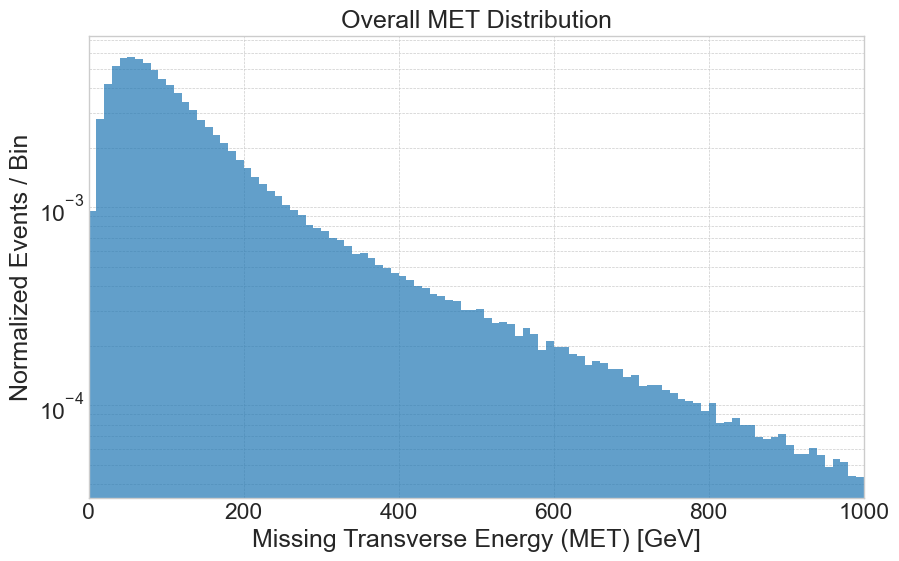

In [15]:
# MET Distribution

plt.style.use('seaborn-v0_8-whitegrid') # Optional: Use a nice style
plt.figure(figsize=(10, 6))

# Define plot range and bins (in GeV)
# Plotting up to 1000 GeV = 1,000,000 MeV. Adjust if needed.
met_range_gev = (0, 1000)
bins = 100

# Plot histogram for ALL events
# Convert MET from MeV to GeV for plotting
plt.hist(all_df['MET'] / 1000,
         bins=bins, weights = all_df['eventWeight'], 
         range=met_range_gev,
         histtype='stepfilled', # Filled histogram for overall view
         alpha=0.7,
         density=True,          # Normalize to unit area (optional, could use False for counts)
         label='All Events')     # Simple label

# Customize the plot
plt.yscale('log') # Use logarithmic scale for y-axis
plt.xlabel('Missing Transverse Energy (MET) [GeV]')
# Adjust Y-axis label if using counts (density=False)
plt.ylabel('Normalized Events / Bin')
plt.title('Overall MET Distribution')
# plt.legend() # Legend might be unnecessary for a single histogram
plt.xlim(met_range_gev) # Set x-axis limits explicitly
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('figures/met_overall_distribution_norm.png', dpi=300)
# Show the plot
plt.show()

In [16]:
# Basic Dataset Statistics

# Count events
total_lvbb = len(x_particles_lvbb)
total_qqbb = len(x_particles_qqbb)
total_events = total_lvbb + total_qqbb

# Count signal and background events
lvbb_signal = np.sum(y_labels_lvbb == 1)
lvbb_background = np.sum(y_labels_lvbb == 0)
qqbb_signal = np.sum(y_labels_qqbb == 1)
qqbb_background = np.sum(y_labels_qqbb == 0)

# Print basic statistics
print("\n--- Processed Dataset Statistics ---")
print(f"Total events: {total_events:,}")
print(f"LVBB channel: {total_lvbb:,} events ({total_lvbb/total_events:.1%})")
print(f"  - Signal: {lvbb_signal:,} ({lvbb_signal/total_lvbb:.1%})")
print(f"  - Background: {lvbb_background:,} ({lvbb_background/total_lvbb:.1%})")
print(f"QQBB channel: {total_qqbb:,} events ({total_qqbb/total_events:.1%})")
print(f"  - Signal: {qqbb_signal:,} ({qqbb_signal/total_qqbb:.1%})")
print(f"  - Background: {qqbb_background:,} ({qqbb_background/total_qqbb:.1%})")


--- Processed Dataset Statistics ---
Total events: 2,172,261
LVBB channel: 1,641,319 events (75.6%)
  - Signal: 887,701 (54.1%)
  - Background: 753,618 (45.9%)
QQBB channel: 530,942 events (24.4%)
  - Signal: 300,245 (56.5%)
  - Background: 230,697 (43.5%)


In [17]:
# Mass and Weight Distributions

category_sels = {
    'All' : np.ones_like(all_df['selection_category']).astype(bool),
    'lvbb' : all_df['selection_category'].isin([0,8,10]),
    'qqbb' : all_df['selection_category'].isin([3, 9])
}
for category in category_sels.keys():
    print('--------------------------------------------------------------')
    print(f'-----------Selcetion category: {category}------------')
    print('--------------------------------------------------------------')
    for dsid in range(510115, 510125):
        dsid_sel = all_df['DSID']==dsid
        sel = dsid_sel & category_sels[category]
        print(f'{dsid}: \t\t{sel.sum():10d} ({(all_df['eventWeight'][sel]).sum():10.5f})')
    sel = ((all_df['DSID']<500000) | (all_df['DSID']>600000)) & category_sels[category]
    print(f'Background: \t\t{sel.sum():10d} ({(all_df['eventWeight'][sel]).sum():10.5f})')
    sel = category_sels[category]
    print(f'All: \t{sel.sum():10d} ({(all_df['eventWeight'][sel]).sum():10.5f})')

--------------------------------------------------------------
-----------Selcetion category: All------------
--------------------------------------------------------------
510115: 		    297190 (38330.87636)
510116: 		    315796 (40414.07351)
510117: 		    327306 (42329.84639)
510118: 		    338945 (44189.89168)
510119: 		    342472 (44372.47081)
510120: 		    345540 (44676.73401)
510121: 		    342179 (45077.47296)
510122: 		    342647 (44956.62894)
510123: 		    340541 (44541.68540)
510124: 		    334507 (44209.30391)
Background: 		   7092702 (397753.25885)
All: 	  10419825 (830852.24280)
--------------------------------------------------------------
-----------Selcetion category: lvbb------------
--------------------------------------------------------------
510115: 		    110094 (15079.33572)
510116: 		    122967 (16537.31951)
510117: 		    131025 (17579.78367)
510118: 		    138064 (19153.28804)
510119: 		    138264 (18899.93298)
510120: 		    138401 (18792.95892)
510121: 		    134539 


Confusion Matrix:
           lvbb      qqbb      other
lvbb   887701.0  201742.0  1138067.0
qqbb    98759.0  300245.0   185862.0
other  676799.0  488740.0  6441910.0


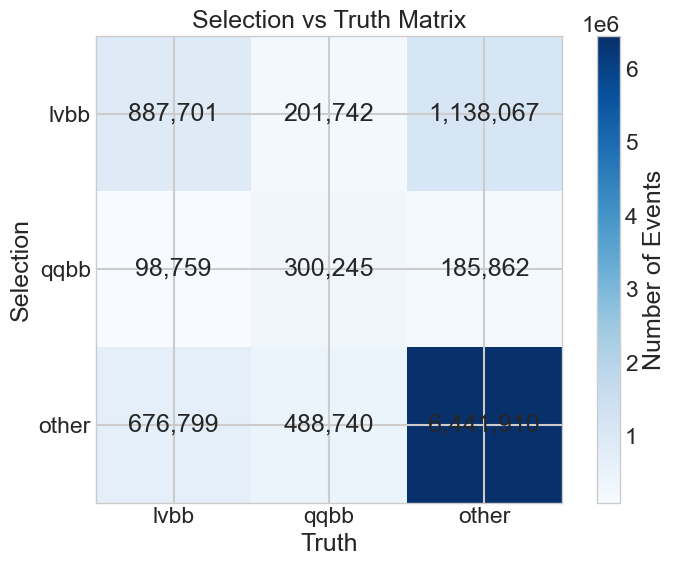

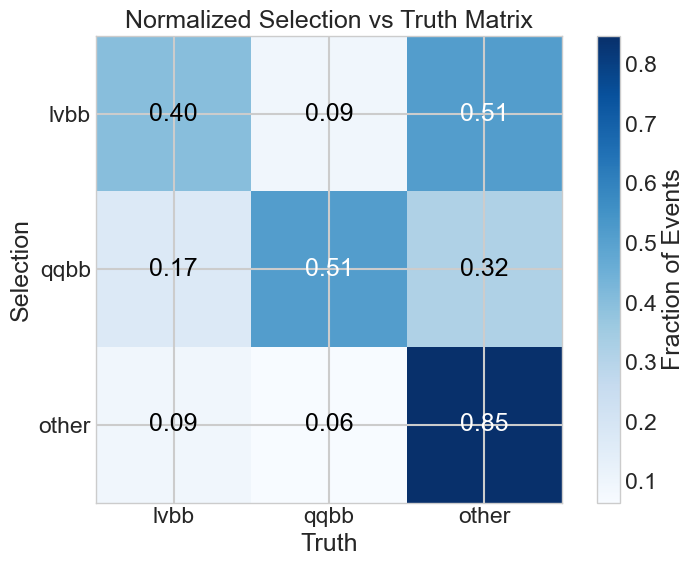

In [18]:
# Confusion Matrix Visualization

# Define the selection and truth categories
lvbb_selected = all_df['selection_category'].isin([0, 8, 10])
qqbb_selected = all_df['selection_category'].isin([3, 9])

# Using numeric for truth_W_decay_mode: 1 = lvbb, 2 = qqbb, other = 0 or null
lvbb_truth = (all_df['truth_W_decay_mode'] == 1)
qqbb_truth = (all_df['truth_W_decay_mode'] == 2)

# Create simple labels
labels = ['lvbb', 'qqbb', 'other']
matrix = np.zeros((3, 3))

# Fill the matrix exactly as specified
matrix[0, 0] = sum(lvbb_selected & lvbb_truth)  # True lvbb
matrix[0, 1] = sum(lvbb_selected & qqbb_truth)  # lvbb selected but qqbb truth
matrix[0, 2] = sum(lvbb_selected & ~(lvbb_truth | qqbb_truth))  # lvbb selected but other truth

matrix[1, 0] = sum(qqbb_selected & lvbb_truth)  # qqbb selected but lvbb truth
matrix[1, 1] = sum(qqbb_selected & qqbb_truth)  # True qqbb
matrix[1, 2] = sum(qqbb_selected & ~(lvbb_truth | qqbb_truth))  # qqbb selected but other truth

matrix[2, 0] = sum(~(lvbb_selected | qqbb_selected) & lvbb_truth)  # not selected but lvbb truth
matrix[2, 1] = sum(~(lvbb_selected | qqbb_selected) & qqbb_truth)  # not selected but qqbb truth
matrix[2, 2] = sum(~(lvbb_selected | qqbb_selected) & ~(lvbb_truth | qqbb_truth))  # true negatives

# Print the matrix
print("\nConfusion Matrix:")
print(pd.DataFrame(matrix, index=labels, columns=labels))

# Create the plot exactly as specified
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='Blues')
plt.colorbar(label='Number of Events')
plt.xticks(range(3), labels)
plt.yticks(range(3), labels)
plt.xlabel('Truth')
plt.ylabel('Selection')
plt.title('Selection vs Truth Matrix')

for i in range(3):
    for j in range(3):
        plt.text(j, i, f'{int(matrix[i, j]):,}', 
                ha='center', va='center')

plt.tight_layout()
plt.savefig('figures/selection_truth_matrix.png', dpi=300)
plt.show()

# Create a normalized version (by row)
row_sums = matrix.sum(axis=1, keepdims=True)
matrix_norm = np.zeros_like(matrix, dtype=float)
np.divide(matrix, row_sums, out=matrix_norm, where=row_sums!=0)

plt.figure(figsize=(8, 6))
plt.imshow(matrix_norm, cmap='Blues')
plt.colorbar(label='Fraction of Events')
plt.xticks(range(3), labels)
plt.yticks(range(3), labels)
plt.xlabel('Truth')
plt.ylabel('Selection')
plt.title('Normalized Selection vs Truth Matrix')

for i in range(3):
    for j in range(3):
        plt.text(j, i, f'{matrix_norm[i, j]:.2f}', 
                ha='center', va='center', 
                color='black' if matrix_norm[i, j] < 0.5 else 'white')

plt.tight_layout()
plt.savefig('figures/normalized_selection_truth_matrix.png', dpi=300)
plt.show()

In [19]:
# Define signal vs background based on DSID
# Signal DSIDs are in range 510115-510124
signal_mask = (all_df['DSID'] >= 510115) & (all_df['DSID'] < 510125)
background_mask = (all_df['DSID'] <= 500000) | (all_df['DSID'] >= 600000)

Creating combined momentum plot...


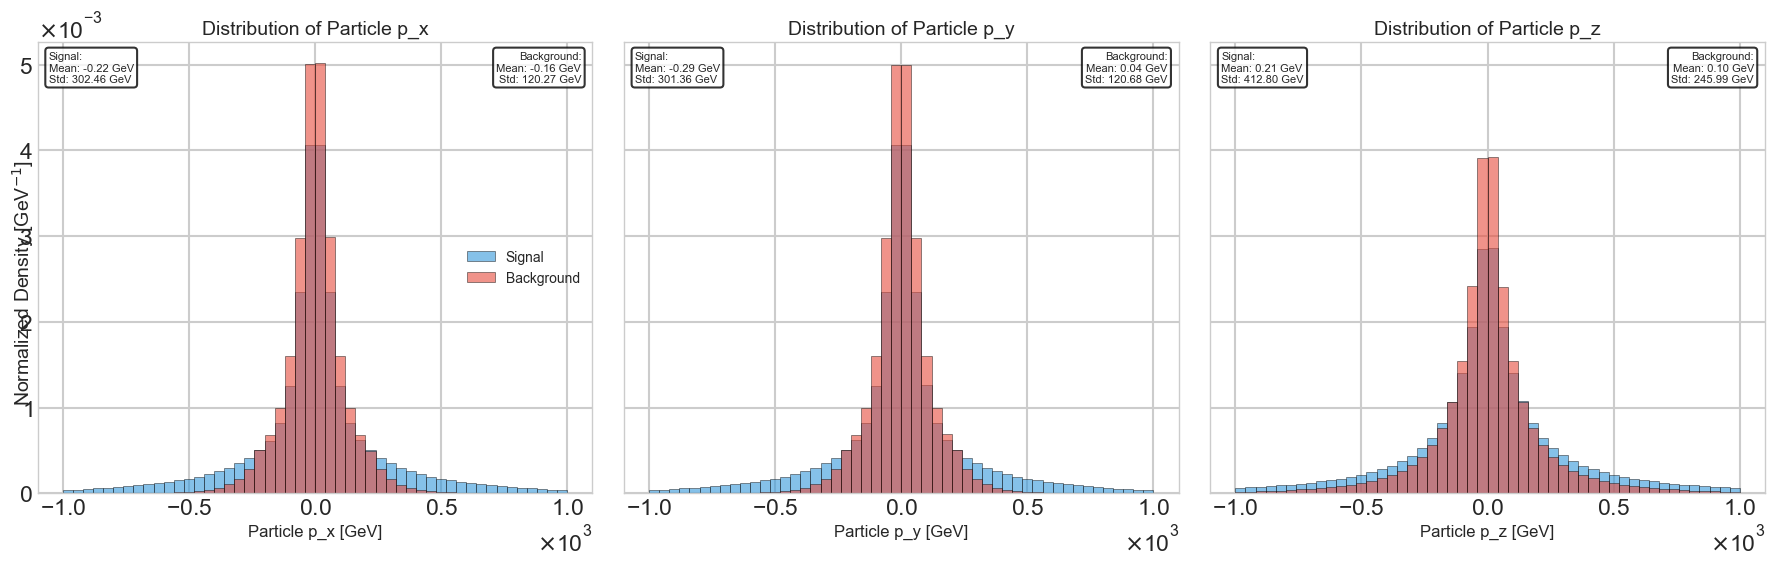

Saved weighted combined momentum plot to figures/combined_momentum_distribution.png
Creating energy distribution plot...


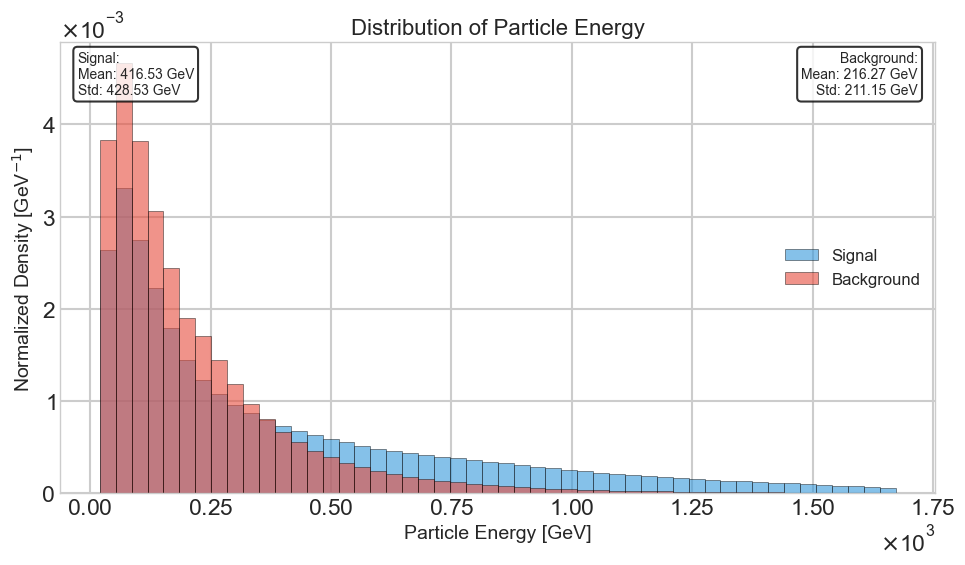

Saved weighted energy distribution plot to figures/energy_distribution.png


In [20]:
# Momentum and Energy Distribution Plotting

def plot_combined_momentum(x_particles, signal_mask, background_mask, all_df):
    """
    Create a combined plot with all three momentum components side by side
    
    Parameters:
    -----------
    x_particles : numpy.ndarray
        Array of particle features
    signal_mask : numpy.ndarray
        Boolean mask for signal events
    background_mask : numpy.ndarray
        Boolean mask for background events
    all_df : pandas.DataFrame
        DataFrame containing event weights
    """
    print("Creating combined momentum plot...")
    
    # Create figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Momentum component names and indices
    components = [
        (0, "p_x"),
        (1, "p_y"),
        (2, "p_z")
    ]
    
    # Use same range for all momentum plots, converting from MeV to GeV
    plot_range = (-1000, 1000)  # -1K to 1K GeV for momentum
    
    # Extract event weights
    signal_weights = all_df.loc[signal_mask, 'eventWeight'].abs().values
    background_weights = all_df.loc[background_mask, 'eventWeight'].abs().values
    
    # Create histograms for each component
    for idx, (feature_idx, name) in enumerate(components):
        ax = axes[idx]
        
        # Extract data for the specified component
        signal_data = x_particles[signal_mask, feature_idx, :].flatten()
        background_data = x_particles[background_mask, feature_idx, :].flatten()
        
        # Remove padding (zeros)
        signal_data_mask = signal_data != 0
        background_data_mask = background_data != 0
        
        signal_data = signal_data[signal_data_mask]
        background_data = background_data[background_data_mask]
        
        # We need to repeat the event weights for each particle in the event
        # Calculate how many particles per event (non-zero values)
        signal_particles_per_event = np.sum(x_particles[signal_mask, feature_idx, :] != 0, axis=1)
        background_particles_per_event = np.sum(x_particles[background_mask, feature_idx, :] != 0, axis=1)
        
        # Create repeated weights arrays matching the flattened particle arrays
        signal_repeated_weights = np.repeat(signal_weights, signal_particles_per_event)
        background_repeated_weights = np.repeat(background_weights, background_particles_per_event)
        
        # Convert MeV to GeV (divide by 1000)
        signal_data = signal_data / 1000.0
        background_data = background_data / 1000.0
        
        # Calculate statistics after conversion to GeV
        # Use weighted mean and std
        signal_mean = np.average(signal_data, weights=signal_repeated_weights)
        signal_std = np.sqrt(np.average((signal_data - signal_mean)**2, weights=signal_repeated_weights))
        bg_mean = np.average(background_data, weights=background_repeated_weights)
        bg_std = np.sqrt(np.average((background_data - bg_mean)**2, weights=background_repeated_weights))
        
        # Adjust weights for density normalization in GeV
        # We need to multiply weights by 1000 because our bin width is in GeV but density should be per GeV
        signal_plot_weights = signal_repeated_weights * 1000
        background_plot_weights = background_repeated_weights * 1000
        
        # Plot histograms with fixed range and weights
        ax.hist(signal_data, bins=50, range=plot_range, weights=signal_plot_weights, 
                density=True, alpha=0.6, label='Signal', color='#3498db', 
                edgecolor='black', linewidth=0.5)
        ax.hist(background_data, bins=50, range=plot_range, weights=background_plot_weights, 
                density=True, alpha=0.6, label='Background', color='#e74c3c', 
                edgecolor='black', linewidth=0.5)
        
        # Use GeV in labels as before
        ax.set_xlabel(f'Particle {name} [GeV]', fontsize=12)
        ax.set_title(f'Distribution of Particle {name}', fontsize=14)
        
        # Force scientific notation on y-axis as well
        ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)
        
        # Statistics text in GeV
        signal_stats = f'Signal:\nMean: {signal_mean:.2f} GeV\nStd: {signal_std:.2f} GeV'
        background_stats = f'Background:\nMean: {bg_mean:.2f} GeV\nStd: {bg_std:.2f} GeV'
        
        ax.text(0.02, 0.98, signal_stats, transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=8)
        
        ax.text(0.98, 0.98, background_stats, transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=8)
        
        # Only add legend to the first subplot
        if idx == 0:
            ax.legend(fontsize=10)
    
    # Add common y-axis label
    fig.text(0.01, 0.5, 'Normalized Density [GeV$^{-1}$]', va='center', rotation='vertical', fontsize=14)
    
    plt.tight_layout()
    plt.savefig('figures/combined_momentum_distribution.png', dpi=300)
    plt.show()
    plt.close()
    print("Saved weighted combined momentum plot to figures/combined_momentum_distribution.png")

def plot_energy_distribution(x_particles, signal_mask, background_mask, all_df):
    """
    Create a separate plot for energy distribution
    
    Parameters:
    -----------
    x_particles : numpy.ndarray
        Array of particle features
    signal_mask : numpy.ndarray
        Boolean mask for signal events
    background_mask : numpy.ndarray
        Boolean mask for background events
    all_df : pandas.DataFrame
        DataFrame containing event weights
    """
    print("Creating energy distribution plot...")
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Extract event weights
    signal_weights = all_df.loc[signal_mask, 'eventWeight'].abs().values
    background_weights = all_df.loc[background_mask, 'eventWeight'].abs().values
    
    # Extract energy data (feature index 3)
    signal_data = x_particles[signal_mask, 3, :].flatten()
    background_data = x_particles[background_mask, 3, :].flatten()
    
    # Remove padding (zeros)
    signal_data_mask = signal_data != 0
    background_data_mask = background_data != 0
    
    signal_data = signal_data[signal_data_mask]
    background_data = background_data[background_data_mask]
    
    # We need to repeat the event weights for each particle in the event
    # Calculate how many particles per event (non-zero values)
    signal_particles_per_event = np.sum(x_particles[signal_mask, 3, :] != 0, axis=1)
    background_particles_per_event = np.sum(x_particles[background_mask, 3, :] != 0, axis=1)
    
    # Create repeated weights arrays matching the flattened particle arrays
    signal_repeated_weights = np.repeat(signal_weights, signal_particles_per_event)
    background_repeated_weights = np.repeat(background_weights, background_particles_per_event)
    
    # Convert MeV to GeV (divide by 1000)
    signal_data = signal_data / 1000.0
    background_data = background_data / 1000.0
    
    # Calculate statistics after conversion to GeV
    # Use weighted mean and std
    signal_mean = np.average(signal_data, weights=signal_repeated_weights)
    signal_std = np.sqrt(np.average((signal_data - signal_mean)**2, weights=signal_repeated_weights))
    bg_mean = np.average(background_data, weights=background_repeated_weights)
    bg_std = np.sqrt(np.average((background_data - bg_mean)**2, weights=background_repeated_weights))
    
    # Use percentile-based range for energy (now in GeV)
    combined_data = np.concatenate([signal_data, background_data])
    q1, q99 = np.percentile(combined_data, [1, 99])
    plot_range = (q1, q99)
    
    # Adjust weights for density normalization in GeV
    # We need to multiply weights by 1000 because our bin width is in GeV but density should be per GeV
    signal_plot_weights = signal_repeated_weights * 1000
    background_plot_weights = background_repeated_weights * 1000
    
    # Plot histograms with weights
    ax.hist(signal_data, bins=50, range=plot_range, weights=signal_plot_weights, 
            density=True, alpha=0.6, label='Signal', color='#3498db', 
            edgecolor='black', linewidth=0.5)
    ax.hist(background_data, bins=50, range=plot_range, weights=background_plot_weights, 
            density=True, alpha=0.6, label='Background', color='#e74c3c', 
            edgecolor='black', linewidth=0.5)
    
    # Keep GeV in labels as before
    ax.set_xlabel('Particle Energy [GeV]', fontsize=14)
    ax.set_ylabel('Normalized Density [GeV$^{-1}$]', fontsize=14)
    ax.set_title('Distribution of Particle Energy', fontsize=16)
    ax.legend(fontsize=12)
    
    # Force scientific notation on both axes
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)
    
    # Statistics text in GeV
    signal_stats = f'Signal:\nMean: {signal_mean:.2f} GeV\nStd: {signal_std:.2f} GeV'
    background_stats = f'Background:\nMean: {bg_mean:.2f} GeV\nStd: {bg_std:.2f} GeV'
    
    ax.text(0.02, 0.98, signal_stats, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=10)
    
    ax.text(0.98, 0.98, background_stats, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=10)
    
    plt.tight_layout()
    plt.savefig('figures/energy_distribution.png', dpi=300)
    plt.show()
    plt.close()
    print("Saved weighted energy distribution plot to figures/energy_distribution.png")

plot_combined_momentum(x_particles, signal_mask, background_mask, all_df)
plot_energy_distribution(x_particles, signal_mask, background_mask, all_df)

Signal events: 3327123
Background events: 7092702

Particle counts:
Electron: Signal=1715938, Background=3387218
Muon: Signal=1611185, Background=3705484
Neutrino: Signal=3327123, Background=7092702
Large-R Jet: Signal=2850202, Background=6771108
Small-R Jet: Signal=19723832, Background=38609964
Figure saved as 'figures/particle_type_distribution.pdf' and 'figures/particle_type_distribution.png'


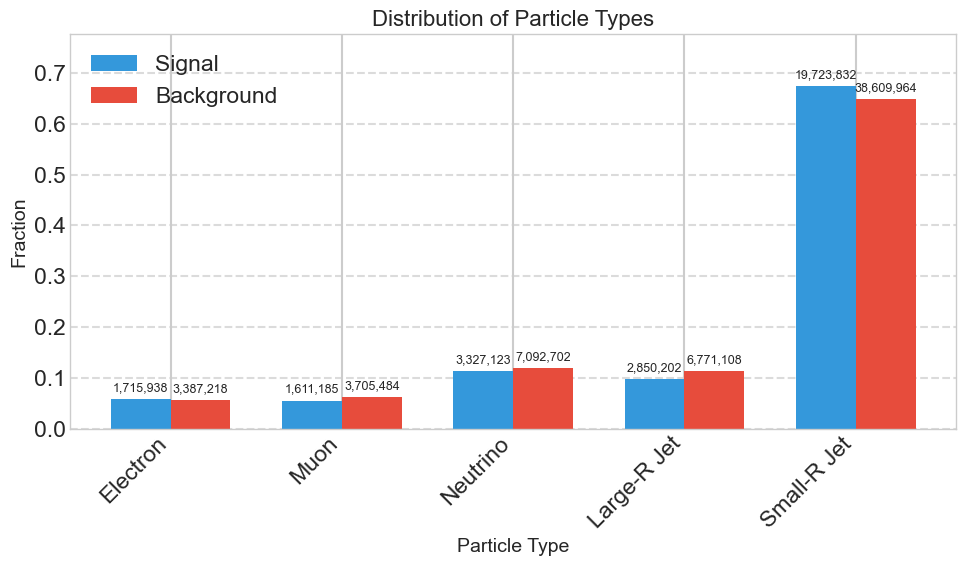

In [21]:
# Plotting the Particle Distributions

print(f"Signal events: {signal_mask.sum()}")
print(f"Background events: {background_mask.sum()}")

# Get particle types from the 5th feature (index 4)
signal_types = x_particles[signal_mask, 4, :].flatten()
background_types = x_particles[background_mask, 4, :].flatten()

# Remove padding (-1) for analysis
signal_types = signal_types[signal_types != -1]
background_types = background_types[background_types != -1]

# Count occurrences of each type
# Particle types are: 0 (electron), 1 (muon), 2 (neutrino), 
#                     3 (large-radius jet), 4 (small-radius jet)
type_labels = ['Electron', 'Muon', 'Neutrino', 'Large-R Jet', 'Small-R Jet']
signal_counts = np.zeros(5)
background_counts = np.zeros(5)

for i in range(5):
    signal_counts[i] = np.sum(signal_types == i)
    background_counts[i] = np.sum(background_types == i)

# Print counts for verification
print("\nParticle counts:")
for i, label in enumerate(type_labels):
    print(f"{label}: Signal={int(signal_counts[i])}, Background={int(background_counts[i])}")

# Normalize to fraction
signal_fracs = signal_counts / np.sum(signal_counts)
background_fracs = background_counts / np.sum(background_counts)

# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot as a grouped bar chart
x = np.arange(len(type_labels))
width = 0.35

ax.bar(x - width/2, signal_fracs, width, label='Signal', color='#3498db')
ax.bar(x + width/2, background_fracs, width, label='Background', color='#e74c3c')

# Add counts as text
for i, (sig_count, bg_count) in enumerate(zip(signal_counts, background_counts)):
    ax.text(i - width/2, signal_fracs[i] + 0.01, f'{int(sig_count):,}', 
            ha='center', va='bottom', fontsize=9, rotation=0)
    ax.text(i + width/2, background_fracs[i] + 0.01, f'{int(bg_count):,}', 
            ha='center', va='bottom', fontsize=9, rotation=0)

# Add labels and title
ax.set_xlabel('Particle Type', fontsize=14)
ax.set_ylabel('Fraction', fontsize=14)
ax.set_title('Distribution of Particle Types', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(type_labels, rotation=45, ha='right')
ax.legend()

# Set y-axis limit to provide space for the text
ax.set_ylim(0, max(np.max(signal_fracs), np.max(background_fracs)) * 1.15)

# Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('figures/particle_type_distribution.png', dpi=300)
print("Figure saved as 'figures/particle_type_distribution.pdf' and 'figures/particle_type_distribution.png'")
plt.show()

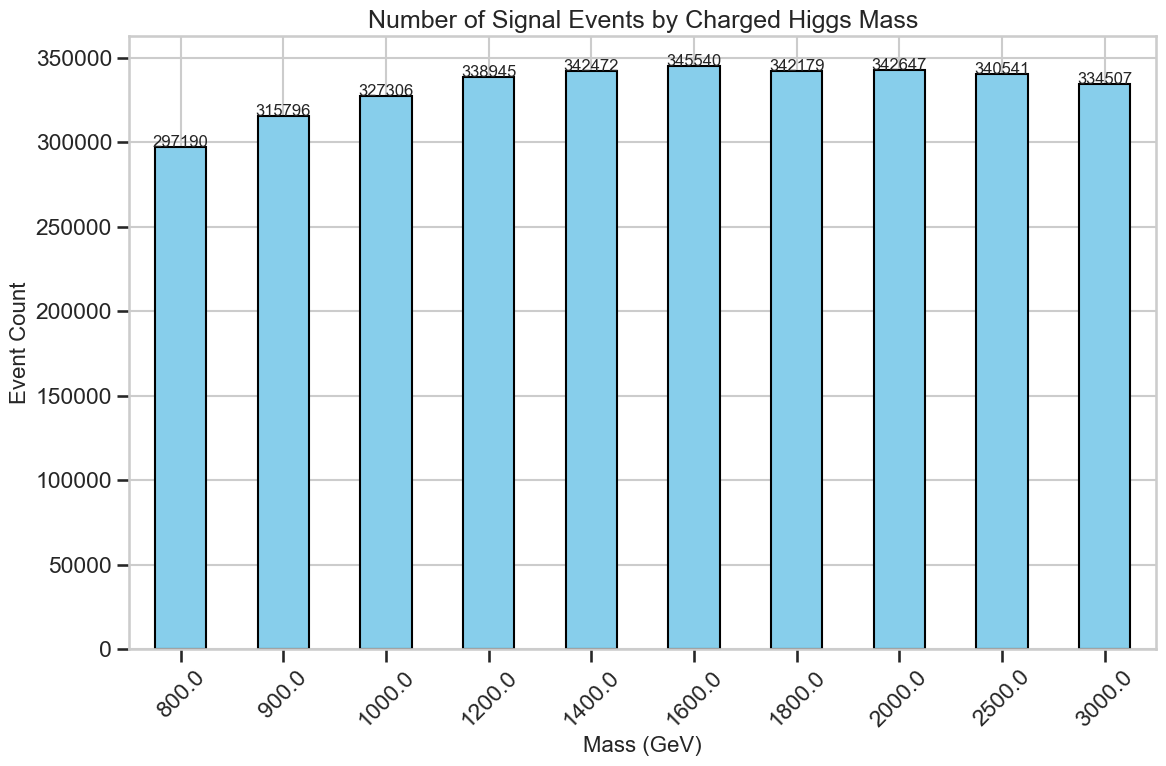

In [22]:
# Mass Distribution Plotting

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)

# Function to plot just the first mass distribution
def plot_single_mass_distribution(all_df):
    """Create only the first mass distribution plot for charged Higgs bosons"""
    # Define the mass mapping for each DSID
    mass_mapping = {
        510115: 800,
        510116: 900,
        510117: 1000,
        510118: 1200,
        510119: 1400,
        510120: 1600,
        510121: 1800,
        510122: 2000,
        510123: 2500,
        510124: 3000
    }
    
    # Add mass column to the dataframe
    all_df['mass'] = all_df['DSID'].map(mass_mapping)
    
    # Define selection categories
    category_sels = {
        'All': np.ones_like(all_df['selection_category']).astype(bool),
        'lvbb': all_df['selection_category'].isin([0, 8, 10]),
        'qqbb': all_df['selection_category'].isin([3, 9])
    }
    
    # Create the plot - ONLY the raw count distribution for all events by mass
    plt.figure(figsize=(12, 8))
    
    # Filter signal events
    signal_df = all_df[all_df['mass'].notna()]
    
    # Get counts by mass
    signal_counts = signal_df.groupby('mass').size()
    
    # Create the bar plot
    ax = signal_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Number of Signal Events by Charged Higgs Mass', fontsize=18)
    plt.xlabel('Mass (GeV)', fontsize=16)
    plt.ylabel('Event Count', fontsize=16)
    plt.xticks(rotation=45)
    
    # Add text labels on top of each bar
    for i, count in enumerate(signal_counts):
        plt.text(i, count + 5, str(count), ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('figures/mass_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()


plot_single_mass_distribution(all_df)

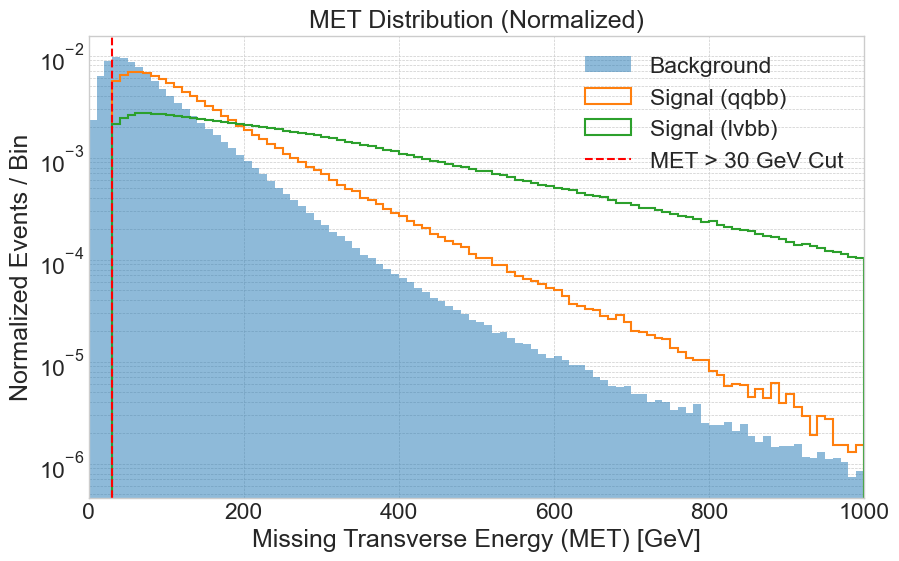

In [23]:
# MET Distribution with cut + Signals for Both Channels 

# Define masks for signal decay channels using truth_W_decay_mode [cite: 181]
# Apply these masks *only* to the signal events
signal_lvbb_mask = signal_mask & (all_df['truth_W_decay_mode'] == 1)
signal_qqbb_mask = signal_mask & (all_df['truth_W_decay_mode'] == 2)

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid') # Optional: Use a nice style
plt.figure(figsize=(10, 6))

# Define plot range and bins (in GeV)
# Plotting up to 1000 GeV = 1,000,000 MeV. Adjust if needed.
met_range_gev = (0, 1000)
bins = 100

# Plot histogram for Background
# Convert MET from MeV to GeV for plotting
plt.hist(all_df.loc[background_mask, 'MET'] / 1000,
         bins=bins, range=met_range_gev,
         histtype='stepfilled', # Use filled for background
         alpha=0.5,            # Make slightly transparent
         density=True,         # Normalize to unit area
         label='Background')

# Plot histogram for Signal qqbb
plt.hist(all_df.loc[signal_qqbb_mask, 'MET'] / 1000,
         bins=bins, range=met_range_gev,
         histtype='step',      # Use step for signal
         linewidth=1.5,
         density=True,         # Normalize to unit area
         label='Signal (qqbb)')

# Plot histogram for Signal lvbb
plt.hist(all_df.loc[signal_lvbb_mask, 'MET'] / 1000,
         bins=bins, range=met_range_gev,
         histtype='step',      # Use step for signal
         linewidth=1.5,
         density=True,         # Normalize to unit area
         label='Signal (lvbb)')

# Add MET cut line (30 GeV)
plt.axvline(30, color='red', linestyle='--', linewidth=1.5, label='MET > 30 GeV Cut')

# Customize the plot
plt.yscale('log') # Use logarithmic scale for y-axis
plt.xlabel('Missing Transverse Energy (MET) [GeV]')
plt.ylabel('Normalized Events / Bin')
plt.title('MET Distribution (Normalized)')
plt.legend()
plt.xlim(met_range_gev) # Set x-axis limits explicitly
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('figures/met_signal_background_comparison_norm.png', dpi=300)
# Show the plot
plt.show()

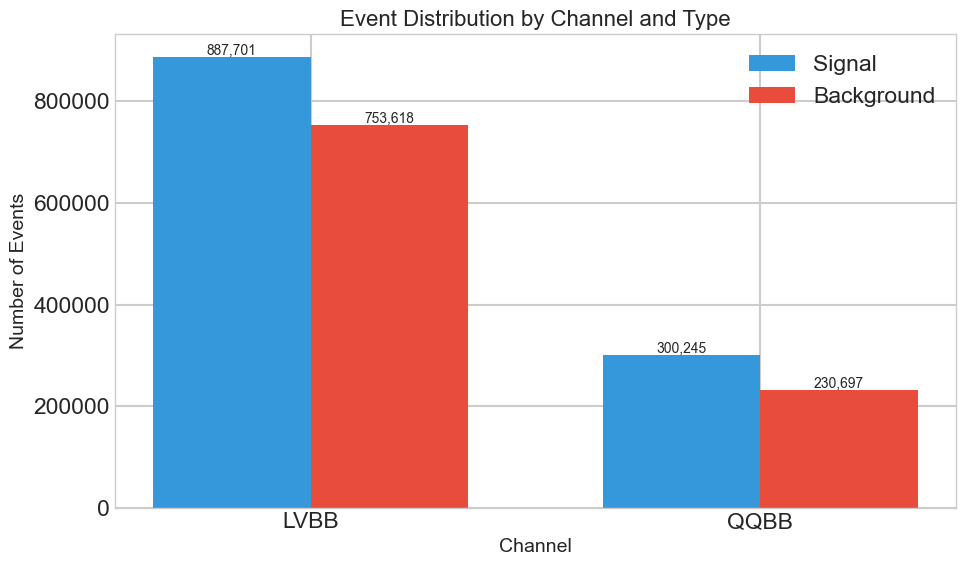

In [24]:
# Channel Distribution 

# Create a bar chart of event counts by channel and signal/background
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
x = np.arange(2)

# Create bars
ax.bar(x - width/2, [lvbb_signal, qqbb_signal], width, label='Signal', color='#3498db')
ax.bar(x + width/2, [lvbb_background, qqbb_background], width, label='Background', color='#e74c3c')

# Add labels and title
ax.set_xlabel('Channel', fontsize=14)
ax.set_ylabel('Number of Events', fontsize=14)
ax.set_title('Event Distribution by Channel and Type', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(['LVBB', 'QQBB'])
ax.legend()

# Add count labels on top of bars
for i, count in enumerate([lvbb_signal, qqbb_signal, lvbb_background, qqbb_background]):
    x_pos = i % 2 - width/2 if i < 2 else i % 2 + width/2
    ax.text(x_pos, count + 5000, f'{count:,}', ha='center', fontsize=10)

# Save the figure
plt.tight_layout()
plt.savefig('figures/channel_distribution.png', dpi=300)
plt.show()
plt.close()
